# Self-Organizing Maps (SOMs) Notebook
## Data extraction for composites

**Notebook by Maria J. Molina (NCAR) and Alice DuVivier (NCAR).**

This Notebook reads in data from the CESM2-LE for a user-specified variable. It subsets the data to be just around Antarctica to create composites from.

In [1]:
# Needed imports

from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

In [2]:
import dask
dask.__version__
# Did a conda update dask on cheyenne to get to 2021.09

'2021.09.1'

In [3]:
# start up dask

cluster = NCARCluster(memory='100 GB', walltime='1:00:00', cores=4, processes=2, resource_spec='select=1:ncpus=2:mem=100GB')
cluster.scale(40) # number of workers requested
#cluster.adapt(1,80) # min and max
client = Client(cluster)

cluster = NCARCluster(memory="100GB", walltime='8:00:00', cores=4, processes=2, resource_spec='select=1:ncpus=2:mem=100GB')
Each worker has 100GB, resource_spec is assigning this. 

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:41605,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Section 1: Load and get correct training data

In [5]:
# set some info for the CESM2-LE data
# set: variable to test, the location of the data, which ensemble member
var_in = 'photoC_TOT_zint' #monthly
 # do not want smbb data
forcing = 'cmip6'

### Load in the data

In [6]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [7]:
subset = cat.search(variable=var_in, forcing_variant=forcing)

In [8]:
#subset
subset.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,photoC_TOT_zint,1850-01,1859-12,185001-185912,Total C Fixation Vertical Integral,mmol/m^3 cm/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,photoC_TOT_zint,1860-01,1869-12,186001-186912,Total C Fixation Vertical Integral,mmol/m^3 cm/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
2,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,photoC_TOT_zint,1870-01,1879-12,187001-187912,Total C Fixation Vertical Integral,mmol/m^3 cm/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
3,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,photoC_TOT_zint,1880-01,1889-12,188001-188912,Total C Fixation Vertical Integral,mmol/m^3 cm/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
4,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,photoC_TOT_zint,1890-01,1899-12,189001-189912,Total C Fixation Vertical Integral,mmol/m^3 cm/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1


In [9]:
# make arrays of half (25) of the CESM2-LE members 
# select every other from the large ensemble of both macro and micro starts
# note that the naming of the files (YYYY.#### e.g. 1001.001) doesn't match the member_id directly, 
# but the ensemble number (### e.g. 001) does match the member_id field r? directly. So use this to search

# set list of members from the dataset
member_ids = subset.df.member_id.unique()

# set list of members to KEEP
keep_list = ['r1i', 'r3i', 'r5i','r7i', 'r9i']


In [10]:
member_keep = [] # make a list to fill

for member in keep_list:
    for member_id in member_ids:
        if member in member_id:
            member_keep.append(member_id)

In [11]:
#check that we're keeping the right ones
member_keep

['r1i1001p1f1',
 'r1i1231p1f1',
 'r1i1251p1f1',
 'r1i1281p1f1',
 'r1i1301p1f1',
 'r3i1041p1f1',
 'r3i1231p1f1',
 'r3i1251p1f1',
 'r3i1281p1f1',
 'r3i1301p1f1',
 'r5i1081p1f1',
 'r5i1231p1f1',
 'r5i1251p1f1',
 'r5i1281p1f1',
 'r5i1301p1f1',
 'r7i1121p1f1',
 'r7i1231p1f1',
 'r7i1251p1f1',
 'r7i1281p1f1',
 'r7i1301p1f1',
 'r9i1161p1f1',
 'r9i1231p1f1',
 'r9i1251p1f1',
 'r9i1281p1f1',
 'r9i1301p1f1']

In [12]:
# now reduce subset based on just the members to keep
subset = subset.search(member_id=member_keep)

In [13]:
%%time
#actually load the data we selected into a dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 13.1 s, sys: 731 ms, total: 13.8 s
Wall time: 23.2 s


In [14]:
# print names of the dataset keys, which refer to each of the ensembles loaded
dsets.keys()

dict_keys(['ocn.ssp370.pop.h.cmip6.photoC_TOT_zint', 'ocn.historical.pop.h.cmip6.photoC_TOT_zint'])

In [15]:
# Look at just one dataset key to see what it looks like. 
# Note that for 1001 there is one member_id, but for 1231 there are 5 member_ids
# these refer to the individual ensemble members!

#dsets['ice.historical.cice.h1.cmip6.1001.aice_d']
#dsets['ice.historical.cice.h1.cmip6.aice_d']

In [16]:
# load in the historical and future datasets

historicals = []
futures = []

for key in sorted(dsets.keys()):
    if 'historical' in key:
        historicals.append(dsets[key])
        print(key)
    elif 'ssp370' in key:
        futures.append(dsets[key])
        print(key)

ocn.historical.pop.h.cmip6.photoC_TOT_zint
ocn.ssp370.pop.h.cmip6.photoC_TOT_zint


In [17]:
# Now put these into an array by member_id
historical_ds = xr.concat(historicals, dim='member_id')
future_ds = xr.concat(futures, dim='member_id')

In [18]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds = xr.concat([historical_ds,future_ds],dim='time')

In [19]:
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound

In [20]:
# we need to shift time by 1 day because of weird CESM conventions
ds = ds.assign_coords(time=ds.coords["time"]-timedelta(days=1))

In [21]:
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 31, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 10, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00

In [22]:
ds

<xarray.Dataset>
Dimensions:                 (time: 3012, member_id: 25, moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, d2: 2)
Coordinates: (12/13)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULONG                   (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
    ULAT                    (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
    TLONG                   (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
    TLAT                    (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
  * time                    (time) object 1850-01-31 00:00:00 ... 2100-12-31 ...
  * member_id               (member_id) <U11 'r1i1001p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat, nlon, d2
Data variables: (12/55)
    moc_components          (time, member_id, moc_comp) |S384 dask.array<chunksize=(1980, 25, 3), meta=np.ndarray>
    transport_components    (time, member_id, transport_comp) |S384 dask.array<chunksize=(1980, 25, 5), meta=np.ndarray>
    transport_regions       (time, member_id, transport_reg) |S384 dask.array<chunksize=(1980, 25, 2), meta=np.ndarray>
    dz                      (time, member_id, z_t) float32 dask.array<chunksize=(1980, 25, 60), meta=np.ndarray>
    dzw                     (time, member_id, z_w) float32 dask.array<chunksize=(1980, 25, 60), meta=np.ndarray>
    KMT                     (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1980, 25, 384, 320), meta=np.ndarray>
    ...                      ...
    salinity_factor         (time, member_id) float64 -0.00347 ... -0.00347
    sflux_factor            (time, member_id) float64 0.1 0.1 0.1 ... 0.1 0.1
    nsurface_t              (time, member_id) float64 8.61e+04 ... 8.61e+04
    nsurface_u              (time, member_id) float64 8.297e+04 ... 8.297e+04
    time_bound              (member_id, time, d2) object dask.array<chunksize=(25, 120, 2), meta=np.ndarray>
    photoC_TOT_zint         (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    NCO:                     netCDF Operators version 4.9.5 (Homepage = http:...
    Conventions:             CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf...
    cell_methods:            cell_methods = time: mean ==> the variable value...
    start_time:              This dataset was created on 2020-07-18 at 07:26:...
    intake_esm_varname:      ['photoC_TOT_zint']
    revision:                $Id$
    ...                      ...
    contents:                Diagnostic and Prognostic Variables
    source:                  CCSM POP2, the CCSM Ocean Component
    calendar:                All years have exactly  365 days.
    title:                   b.e21.BHISTcmip6.f09_g17.LE2-1301.009
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    intake_esm_dataset_key:  ocn.historical.pop.h.cmip6.photoC_TOT_zint

## Section 2: Convert the units (per Kristen's directions)

The variable for NPP is 'photoC_TOT_zint' . It's already depth integrated, so you just have to convert the units from 'mmol/m3 cm/sec' to 'mmol/m2/day' like this:

ds['photoC_TOT_zint'] = ds_fosi.photoC_TOT_zint * 0.01 * 86400.

ds.photoC_TOT_zint.attrs['units'] = 'mmol/m2/d'

In [23]:
# convert units
ds['photoC_TOT_zint'] = ds.photoC_TOT_zint * 0.01 * 86400
ds.photoC_TOT_zint.attrs['units'] = 'mmol/m2/day'

## Section 3: Drop the lats that we don't need

In [24]:
# set some limits for Antarctica in general
lat_max = -60
lat_min = -80

In [25]:
# now drop points that are masked
ds_subset = ds.where(((ds['TLAT']<lat_max) & (ds['TLAT']>lat_min)), drop=True)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

In [26]:
ds_subset = ds_subset[var_in]

In [27]:
ds_subset

,Array,Chunk
Bytes,6.46 GiB,10.55 MiB
Shape,"(25, 3012, 36, 320)","(1, 120, 36, 320)"
Count,6501 Tasks,650 Chunks
Type,float64,numpy.ndarray


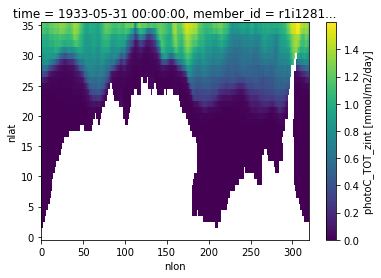

In [28]:
# check that we have all of Antarctica here
ds_subset.sel(member_id='r1i1281p1f1').isel(time=1000).plot()

In [29]:
#%%time
## actually load the data so it doesn't get too big later and makes DASK angry
#ds_subset.load()

## Section 4: Subset the times

In [30]:
ds_subset.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 31, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 10, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00

In [31]:
# keep just years greater than 1980 and less than 2080 
yy_st = "1980"
yy_ed = "2080"
ds_subset = ds_subset.sel(time=slice(yy_st, yy_ed))

In [32]:
ds_subset.time.dt.year

<xarray.DataArray 'year' (time: 1212)>
array([1980, 1980, 1980, ..., 2080, 2080, 2080])
Coordinates:
  * time     (time) object 1980-01-31 00:00:00 ... 2080-12-31 00:00:00

In [33]:
# keep just times corresponding to spring and summer (SH: ONDJFM)
ds_subset_summer = ds_subset.isel(time=ds_subset.time.dt.month.isin([1,2,3,10,11,12]))

In [34]:
ds_subset_summer.time

<xarray.DataArray 'time' (time: 606)>
array([cftime.DatetimeNoLeap(1980, 1, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 2, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 3, 31, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2080, 10, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2080, 11, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2080, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1980-01-31 00:00:00 ... 2080-12-31 00:00:00

In [35]:
%%time
# actually load the data so it doesn't get too big later and makes DASK angry
#ds_subset_winter.persist()
ds_subset_summer.load()

CPU times: user 2.73 s, sys: 2.45 s, total: 5.18 s
Wall time: 11.2 s


<xarray.DataArray 'photoC_TOT_zint' (member_id: 25, time: 606, nlat: 36, nlon: 320)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [2.11993851e-01, 2.88173367e-01, 1.98770724e-01, ...,
                     nan,            nan,            nan],
         ...,
         [3.30549027e+01, 3.55100770e+01, 3.84105390e+01, ...,
          2.61842525e+01, 2.85381624e+01, 3.08228061e+01],
         [2.92712881e+01, 3.20259201e+01, 3.47992153e+01, ...,
          2.41314422e+01, 2.52348938e+01, 2.70503788e+01],
         [2.55074808e+01, 2.71754863e+01, 2.93168672e+01, ...,
          2.67793860e+01, 2.50050821e+01, 2.46541863e+01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [1.14488307e-01, 1.78622567e-01, 1.38293053e-01, ...,
                     nan,            nan,            nan],
...
         [1.07492628e+01, 1.01528851e+01, 9.80033597e+00, ...,
          1.37933106e+01, 1.26198609e+01, 1.16046494e+01],
         [1.23607406e+01, 1.18442088e+01, 1.16737938e+01, ...,
          1.60195897e+01, 1.44725440e+01, 1.32365984e+01],
         [1.57029034e+01, 1.55437738e+01, 1.57900911e+01, ...,
          2.03970957e+01, 1.80491678e+01, 1.64148287e+01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [1.82328617e-02, 2.30588268e-02, 2.16611747e-02, ...,
                     nan,            nan,            nan],
         ...,
         [6.26184342e+01, 6.21634880e+01, 6.21618535e+01, ...,
          5.91101451e+01, 6.15734389e+01, 6.25461152e+01],
         [6.84488291e+01, 6.96517697e+01, 7.00456420e+01, ...,
          5.94277907e+01, 6.31521620e+01, 6.62290866e+01],
         [7.03255238e+01, 7.31960122e+01, 7.49008862e+01, ...,
          5.85880548e+01, 6.25461604e+01, 6.66149223e+01]]]])
Coordinates:
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -60.25 -60.25
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -60.52 -60.52
  * time       (time) object 1980-01-31 00:00:00 ... 2080-12-31 00:00:00
  * member_id  (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nlat, nlon
Attributes:
    units:    mmol/m2/day

## Section 5: Sum over growth season following winter

Units are 'mmol/m2/day' so multiply each month by the days in the month and then sum over growth season

Spring and Summer: ONDJFM = 31,30,31,31,28,31 days/month

In [36]:
years_all = ds_subset_summer.coords['time.year'][(ds_subset_summer.coords['time.month']==1)]

In [95]:
years_all[0:100]

<xarray.DataArray 'year' (time: 100)>
array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034,
       2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045,
       2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056,
       2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067,
       2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078,
       2079])
Coordinates:
  * time     (time) object 1980-01-31 00:00:00 ... 2079-01-31 00:00:00

In [103]:
# Loop through years to get total NPP that growth season

# make numpy array to fill and specify dimensions we want
yearly_array = np.zeros([len(ds_subset_summer.member_id),len(years_all),len(ds_subset_summer.nlat),len(ds_subset_summer.nlon)])

# loop through all years but the last year
for yy in years_all[0:100]:
    if yy == 1980: 
        y_count = 0
    else:
        y_count = y_count + 1
    # get the years: OND is in year yy, JMF will be in **next** year
    temp0 = ds_subset_summer.isel(time=ds_subset_summer.time.dt.year.isin([yy]))
    temp1 = ds_subset_summer.isel(time=ds_subset_summer.time.dt.year.isin([yy+1]))
    ### now get months for each of the years
    # oct - 31 days
    oct_tmp = temp0.isel(time=temp0.time.dt.month.isin([10])) * 31
    oct_tmp = oct_tmp.isel(time=0).values
    # nov - 30 days
    nov_tmp = temp0.isel(time=temp0.time.dt.month.isin([11])) * 30
    nov_tmp = nov_tmp.isel(time=0).values
    # dec - 31 days
    dec_tmp = temp0.isel(time=temp0.time.dt.month.isin([12])) * 31
    dec_tmp = dec_tmp.isel(time=0).values
    # jan - 31 days
    jan_tmp = temp1.isel(time=temp1.time.dt.month.isin([1])) * 31
    jan_tmp = jan_tmp.isel(time=0).values
    # feb - 28 days
    feb_tmp = temp1.isel(time=temp1.time.dt.month.isin([2])) * 28
    feb_tmp = feb_tmp.isel(time=0).values
    # mar - 31 days
    mar_tmp = temp1.isel(time=temp1.time.dt.month.isin([3])) * 31
    mar_tmp = mar_tmp.isel(time=0).values   
    ### now sum them all up
    npp_tmp = oct_tmp + nov_tmp + dec_tmp + jan_tmp + feb_tmp + mar_tmp
    # enter in the array
    yearly_array[:,y_count,:,:] = npp_tmp 
    

In [109]:
print(yearly_array.shape)

(25, 101, 36, 320)


In [110]:
# convert the numpy array to a xarray for easier plotting
ds_total_summer = xr.DataArray(yearly_array,dims=('member_id','time','nlat','nlon'))

In [111]:
# set coordinate arrays
ds_total_summer['time'] = years_all.values
ds_total_summer['member_id'] = ds_subset_summer['member_id']
ds_total_summer['nlat'] = ds_subset_summer['nlat'].values
ds_total_summer['nlon'] = ds_subset_summer['nlon'].values

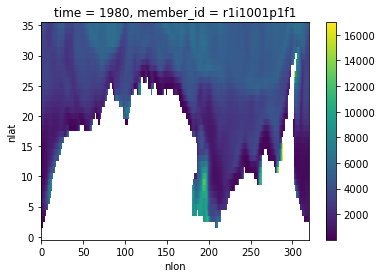

In [129]:
ds_total_summer.isel(time=0,member_id=0).plot()

## Section 4: Save data for making composites

In [114]:
ds_total_summer.shape

(25, 101, 36, 320)

In [115]:
# Flatten the times and member_id
subset_for_composites = ds_total_summer.stack(new=("member_id","time"))

In [116]:
subset_for_composites

<xarray.DataArray (nlat: 36, nlon: 320, new: 2525)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
...
        [4.57991531e+03, 5.88803216e+03, 5.22858231e+03, ...,
         4.81886825e+03, 4.58509870e+03, 0.00000000e+00],
        [4.24978938e+03, 5.72303016e+03, 5.01966484e+03, ...,
         4.85842766e+03, 4.47298593e+03, 0.00000000e+00],
        [3.99089604e+03, 5.50796977e+03, 4.73858280e+03, ...,
         4.83774275e+03, 4.34625498e+03, 0.00000000e+00]],

       [[4.25683066e+03, 5.46113276e+03, 5.17680475e+03, ...,
         4.56240407e+03, 4.33476635e+03, 0.00000000e+00],
        [4.17715128e+03, 5.33671690e+03, 4.86230149e+03, ...,
         4.57428101e+03, 4.22703529e+03, 0.00000000e+00],
        [4.12404771e+03, 5.21669753e+03, 4.52296124e+03, ...,
         4.59822746e+03, 4.13237531e+03, 0.00000000e+00],
        ...,
        [4.89029441e+03, 5.98823840e+03, 5.71053437e+03, ...,
         4.56009398e+03, 4.78397800e+03, 0.00000000e+00],
        [4.66954638e+03, 5.81253632e+03, 5.62715195e+03, ...,
         4.56778911e+03, 4.61501221e+03, 0.00000000e+00],
        [4.41758447e+03, 5.62355647e+03, 5.45181985e+03, ...,
         4.56585774e+03, 4.45908165e+03, 0.00000000e+00]]])
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35
  * nlon       (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * new        (new) MultiIndex
  - member_id  (new) object 'r1i1001p1f1' 'r1i1001p1f1' ... 'r9i1301p1f1'
  - time       (new) int64 1980 1981 1982 1983 1984 ... 2076 2077 2078 2079 2080

In [117]:
# assign to numpy array object
subsetarray = subset_for_composites.values

In [118]:
subsetarray.shape

(36, 320, 2525)

In [120]:
ds_subset_summer.TLAT.values

array([[-79.22052261, -79.22052261, -79.22052261, ..., -79.22052261,
        -79.22052261, -79.22052261],
       [-78.68630626, -78.68630626, -78.68630626, ..., -78.68630626,
        -78.68630626, -78.68630626],
       [-78.15208992, -78.15208992, -78.15208992, ..., -78.15208992,
        -78.15208992, -78.15208992],
       ...,
       [-61.59125009, -61.59125009, -61.59125009, ..., -61.59125009,
        -61.59125009, -61.59125009],
       [-61.05702397, -61.05702397, -61.05702397, ..., -61.05702397,
        -61.05702397, -61.05702397],
       [-60.52279743, -60.52279743, -60.52279743, ..., -60.52279743,
        -60.52279743, -60.52279743]])

## Section 5: Save data as a netcdf

In [121]:
fout = 'antarctic_data_for_som_composites_NPP_total'

In [124]:
# set some info for output
longname = 'Net Primary Productivity over summer (ONDJFM) season'
print(longname)
units = 'mmol/m2'
print(units)

Net Primary Productivity over summer (ONDJFM) season
mmol/m2


In [126]:
ds_to_save = xr.Dataset({'data': (['nlat','nlon','training_times'], subsetarray)}, 
                        coords={'time':(['training_times'],subset_for_composites.time.values),
                                'member_id':(['training_times'],subset_for_composites.member_id.values),
                                'TLONG':(['nlat','nlon'],ds_subset_summer.TLONG.values),
                                'TLAT':(['nlat','nlon'],ds_subset_summer.TLAT.values),
                                'nlat':(['nlat'],ds_subset_summer.nlat.values),
                                'nlon':(['nlon'],ds_subset_summer.nlon.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [127]:
ds_to_save

<xarray.Dataset>
Dimensions:    (nlat: 36, nlon: 320, training_times: 2525)
Coordinates:
    time       (training_times) int64 1980 1981 1982 1983 ... 2078 2079 2080
    member_id  (training_times) object 'r1i1001p1f1' ... 'r9i1301p1f1'
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -60.52 -60.52
  * nlat       (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35
  * nlon       (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
Dimensions without coordinates: training_times
Data variables:
    data       (nlat, nlon, training_times) float64 nan nan ... 4.459e+03 0.0
Attributes:
    Author:    Alice DuVivier
    units:     mmol/m2
    longname:  Net Primary Productivity over summer (ONDJFM) season

In [128]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file

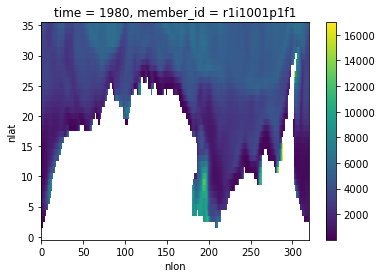

In [132]:
ds_total_summer.isel(time=0,member_id=0).plot()

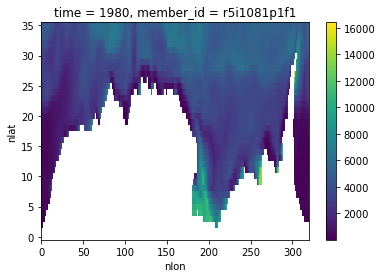

In [133]:
ds_total_summer.isel(time=0,member_id=10).plot()